In [2]:
from tensorflow import keras
from tensorflow.keras.models import load_model
import pickle

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from scipy import interp
from sklearn.model_selection import StratifiedKFold

import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import pandas as pd
import glob 
import os 

In [5]:
models1 = glob.glob('/Users/home/Documents/asthma_vgg16/*/')
models2 = glob.glob('/Users/home/Documents/copd_vgg16/*/')
models3 = glob.glob('/Users/home/Documents/covid_vgg16/*/')
models4 = glob.glob('/Users/home/Documents/healthy_vgg16/*/')

In [6]:
fh1 = open("/Users/home/Documents/Respiratory Illness AI/datasets/official_datasets/others/asthma_others_224_224_3", 'rb')
dataset1 = pickle.load(fh1)
fh2 = open("/Users/home/Documents/Respiratory Illness AI/datasets/official_datasets/others/copd_others_224_224_3", 'rb')
dataset2 = pickle.load(fh2)
fh3 = open("/Users/home/Documents/Respiratory Illness AI/datasets/official_datasets/others/covid_others_224_224_3", 'rb')
dataset3 = pickle.load(fh3)
fh4 = open("/Users/home/Documents/Respiratory Illness AI/datasets/official_datasets/others/healthy_others_224_224_3", 'rb')
dataset4 = pickle.load(fh4)

In [7]:
def train_val(dataset):
    input_shape = (224, 224, 3)
    train = dataset[:139]
    val = dataset[139:174]
    #278 - 5, 261 - 4
    #130 - 4, 

    X_train, y_train = zip(*train)
    X_val, y_val = zip(*val)

    X_train = np.array([x.reshape(input_shape) for x in X_train])
    X_val = np.array([x.reshape(input_shape) for x in X_val])

    y_train = np.array(np_utils.to_categorical(y_train, 2))
    y_val = np.array(np_utils.to_categorical(y_val, 2))
    
    return X_val, y_val 

In [7]:
def get_auc_values(models, X_val, y_val):
    base_fpr = np.linspace(0, 1, 100)
    
    tprs = []
    aucs = []

    for i in models:
        model = load_model(i, compile = True)
        y_score = model.predict(X_val)
        fpr, tpr, thresholds = roc_curve(y_val.argmax(axis=1), y_score[:,1])
        tprs.append(np.interp(base_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
    return tprs, aucs

In [1]:
def graph_average(tprs, base_fpr, aucs):

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow"])
    diseases = ["healthy", "asthma", "copd", "covid"]
    lw = 2
    
    plt.figure(figsize=(5, 5))
    plt.axes().set_aspect('equal', 'datalim')
    
    for i, colour in zip(range(4), colors):
        mean_tpr = np.mean(tprs[i], axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = sum(aucs[i])/5
        print(mean_auc)
        plt.plot(base_fpr[i], mean_tpr, color=colour,
         label=f'ROC class {diseases[i]} (AUC = {round(mean_auc, 2)})',lw=2, alpha=1)

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

0.7342105263157894
0.7
0.8732026143790851
0.7085526315789473


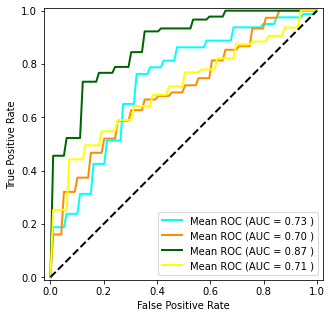

In [39]:
all_models = [models4, models1, models2, models3]
all_datasets = [dataset4, dataset1, dataset2, dataset3]

base_fpr = np.linspace(0, 1, 100)

all_tprs = []
all_base_fprs = []
all_aucs = []

for i in range(len(all_models)):
    X_val, y_val = train_val(all_datasets[i])
    tprs, aucs = get_auc_values(all_models[i], X_val, y_val)
    all_tprs.append(tprs)
    all_base_fprs.append(base_fpr)
    all_aucs.append(aucs)

graph_average(all_tprs, all_base_fprs, all_aucs)